# TIMESERIES ANALYSIS

# Business Understanding

This project focuses on the application of time series regression analysis to forecast sales for Corporation Favorita, a prominent grocery retailer based in Ecuador.

The primary objective is to develop a robust model capable of accurately forecasting future sales by leveraging the extensive time series data of thousands of products sold across various Favorita locations. The resulting forecasts will provide valuable insights to the store's management, enabling them to formulate effective inventory and sales plans.

Through this research, we will construct models based on historical analysis, establish scientific hypothesis using time-stamped historical data, and employ these models to observe patterns and guide strategic decision-making in the future. By delving into the data, our aim is to optimize operations and ultimately drive sales growth for Favorita Corporation, supporting the management team in extracting meaningful insights from their vast dataset.

# Hypothesis

Null Hypothesis: Sales are not affected by promotion, oil prices and holidays.

Alternate Hypothesis: Sales are affected by promotion, oil prices and holidays.

# Analytical Questions

1. Is the train dataset complete (has all the required dates)?

2. Which dates have the lowest and highest sales for each year?

3. Did the earthquake impact sales?

4. Are certain groups of stores selling more products? (Cluster, city, state, type)

5. Are sales affected by promotions, oil prices and holidays?

6. What analysis can we get from the date and its extractable features?

7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

In [1]:
# Importing the needed packages
import pandas as pd
import numpy as np
import matplotlib.dates as ndates

# Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries to create connection string to SQL server
import pyodbc
from dotenv import dotenv_values

# Library for imputing missing values
from sklearn.impute import SimpleImputer

# Library for checking stationarity
from statsmodels.tsa.stattools import adfuller

# Library for modelling
from sklearn.linear_model import LinearRegression

# Library for working with operating system
import os

# Library to handle warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-v0_8")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

# Data Understanding

### Accessing and loading the datasets

The first dataset was collected from a SQL database by first passing a connection string using the pyodbc library. Afterwards a SQL query was used to obtain the dataset. This is as shown below.

In [3]:
# Load the environment variable in the .env file into a dictionary

environment_variables = dotenv_values('.env')

# Get the values for the credentials you set in the .env file
server = environment_variables.get('SERVER')
database = environment_variables.get('DATABASE')
username = environment_variables.get('USERNAME')
password = environment_variables.get('PASSWORD')

# The connection string is an f string that includes all the variable above to establish a connection to the server.
connection_string = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}'

In [4]:
# Use the connect method of the pyodbc library to pass in the connection string.
# Check your internet connection if it takes more time than necessary.

connection = pyodbc.connect(connection_string)

# Get the oil dataset using the SQL query shown below
query1 = 'Select * from dbo.oil'
oil = pd.read_sql(query1, connection)

# Get the holiday dataset using the SQL query shown below
query2 = 'Select * from dbo.holidays_events'
holiday = pd.read_sql(query2, connection)

# Get the stores dataset using the SQL query shown below
query3 = 'Select * from dbo.stores'
stores = pd.read_sql(query3, connection)

# Save the datasets
oil.to_csv(r'oil.csv')
holiday.to_csv(r'holiday.csv')
stores.to_csv(r'stores.csv')

In [ ]:
# Close connection

connection.close

In [5]:
# Loading the other datasets

sample_submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
transactions = pd.read_csv('transactions.csv')

### EDA

In [6]:
# Evaluating the first five rows of the holiday dataset

holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [7]:
# Checking for missing values and the datatypes of the columns in the holiday dataset

holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [8]:
# Checking for duplicates on the holiday dataset

holiday.duplicated().sum()

0

In [9]:
# Evaluating the first five rows of the oil dataset

oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [10]:
# Checking for missing values and the datatypes of the columns in the oil dataset

oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [11]:
# Counting the missing values in the oil datast

oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [12]:
# Checking for duplicates on the oil dataset

oil.duplicated().sum()

0

In [13]:
# Evaluating the first five rows of the stores dataset

stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [14]:
# Checking for missing values and the datatypes of the columns in the holiday dataset

stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [15]:
# Checking for duplicates on the stores dataset

stores.duplicated().sum()

0

In [16]:
# Evaluating the first five rows of the sample_submission dataset

sample_submission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [17]:
# Checking for missing values and the datatypes of the columns in the sample_submission dataset

sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      28512 non-null  int64  
 1   sales   28512 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 445.6 KB


In [18]:
# Checking for duplicates on the sample_submission dataset

sample_submission.duplicated().sum()

0

In [19]:
# Evaluating the first five rows of the test dataset

test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [20]:
# Checking for missing values and the datatypes of the columns in the test dataset

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [21]:
# Checking for duplicates on the test dataset

test.duplicated().sum()

0

In [22]:
# Evaluating the first five rows of the train dataset

train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [23]:
# Checking the datatypes of the columns in the train dataset

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [24]:
# Checking for missing values in the train dataset

train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [25]:
# Checking for duplicates on the train dataset

train.duplicated().sum()

0

In [26]:
# Evaluating the first five rows of the transactions dataset

transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [27]:
# Checking for missing values and the datatypes of the columns in the transactions dataset

transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [28]:
# Checking for duplicates on the transactions dataset

transactions.duplicated().sum()

0

# Problems Identified

The oil dataset has 43 missing values on the 'dcoilwtico' column.

For all the datasets that have a 'date' column, the 'date' column is present as object datatype instead of datetime datatype.

The datasets are seperate, and need to be merged together for better analysis.

# Data Preparation

The problems identified with the datasets will be handled to prepare the data for analysis and modelling.

### Filling missing values

In [29]:
# create an instance of the SimpleImputer class with mean strategy
imputer = SimpleImputer(strategy='mean')

# fit the imputer to the 'dcoilwtico' column of oil dataset
imputer.fit(oil[['dcoilwtico']])

# Impute missing values on the 'dcoilwtico' column of oil dataset with the imputer
oil['dcoilwtico'] = imputer.transform(oil[['dcoilwtico']])

oil.head()

,date,dcoilwtico
0,2013-01-01,67.714366
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


### Combine the datasets based on common columns

In [30]:
# Merge transactions dataset to train on 'date' and 'store_nbr' columns
df1 = pd.merge(train, transactions, on=['date', 'store_nbr'])

# Merge holiday dataset to df1 on 'date' column
df2 = pd.merge(df1, holiday, on='date')

# Merge oil dataset to df2 on 'date' column
df3 = pd.merge(df2, oil, on='date')
df3

# Merge store dataset to df3 on 'store_nbr' column
df4 = pd.merge(df3, stores, on='store_nbr')

df4.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,type_x,locale,locale_name,description,transferred,dcoilwtico,city,state,type_y,cluster
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,67.714366,Salinas,Santa Elena,D,1
1,562,2013-01-01,25,BABY CARE,0.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,67.714366,Salinas,Santa Elena,D,1
2,563,2013-01-01,25,BEAUTY,2.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,67.714366,Salinas,Santa Elena,D,1
3,564,2013-01-01,25,BEVERAGES,810.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,67.714366,Salinas,Santa Elena,D,1
4,565,2013-01-01,25,BOOKS,0.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,67.714366,Salinas,Santa Elena,D,1


### Change the datatype of the 'date' column from object to datetime

In [31]:
df4['date'] = pd.to_datetime(df4['date'])

df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            322047 non-null  int64         
 1   date          322047 non-null  datetime64[ns]
 2   store_nbr     322047 non-null  int64         
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  int64         
 6   transactions  322047 non-null  int64         
 7   type_x        322047 non-null  object        
 8   locale        322047 non-null  object        
 9   locale_name   322047 non-null  object        
 10  description   322047 non-null  object        
 11  transferred   322047 non-null  bool          
 12  dcoilwtico    322047 non-null  float64       
 13  city          322047 non-null  object        
 14  state         322047 non-null  object        
 15  type_y        322

The missing values in the 'dcoilwtico' column of the oil dataset have been filled, the datasets have been merged and the datatype of the 'date' column has been changed from object to datetime.

In [32]:
# Evaluating 'type_x' column on df4

df4['type_x'].unique()

array(['Holiday', 'Additional', 'Transfer', 'Event', 'Bridge'],
      dtype=object)

In [33]:
# Evaluating 'type_y' column on df4

df4['type_y'].unique()

array(['D', 'C', 'B', 'E', 'A'], dtype=object)

In [34]:
# Rename 'type_x' and type_y' to 'holiday_type' and 'store_type' respectively

df4 = df4.rename(columns={'type_x': 'holiday_type', 'type_y': 'store_type'})
df4.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico,city,state,store_type,cluster
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,67.714366,Salinas,Santa Elena,D,1
1,562,2013-01-01,25,BABY CARE,0.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,67.714366,Salinas,Santa Elena,D,1
2,563,2013-01-01,25,BEAUTY,2.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,67.714366,Salinas,Santa Elena,D,1
3,564,2013-01-01,25,BEVERAGES,810.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,67.714366,Salinas,Santa Elena,D,1
4,565,2013-01-01,25,BOOKS,0.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,67.714366,Salinas,Santa Elena,D,1


In [35]:
# Rename df4 to train_data and save the DataFrame

train_merged = df4
train_merged.to_csv(r'train_merged.csv')

In [36]:
# Generate summary statistics for numerical columns in train_data DataFrame

train_merged.describe()

,id,date,store_nbr,sales,onpromotion,transactions,dcoilwtico,cluster
count,3.220470e+05,322047,322047.000000,322047.000000,322047.000000,322047.000000,322047.000000,322047.000000
mean,1.682979e+06,2015-08-04 23:49:57.971103488,26.994672,406.383452,3.727136,1734.117840,64.326826,8.531202
min,5.610000e+02,2013-01-01 00:00:00,1.000000,0.000000,0.000000,54.000000,27.959999,1.000000
25%,1.010616e+06,2014-07-23 00:00:00,13.000000,1.000000,0.000000,1030.000000,44.939999,4.000000
50%,1.842406e+06,2015-11-02 00:00:00,27.000000,19.000000,0.000000,1409.000000,52.720001,9.000000
75%,2.209556e+06,2016-05-27 00:00:00,40.000000,241.260505,1.000000,2148.000000,93.120003,13.000000
max,3.000887e+06,2017-08-15 00:00:00,54.000000,124717.000000,716.000000,8359.000000,107.949997,17.000000
std,7.862493e+05,NaN,15.595174,1246.881240,15.512095,1050.335018,24.289114,4.713809


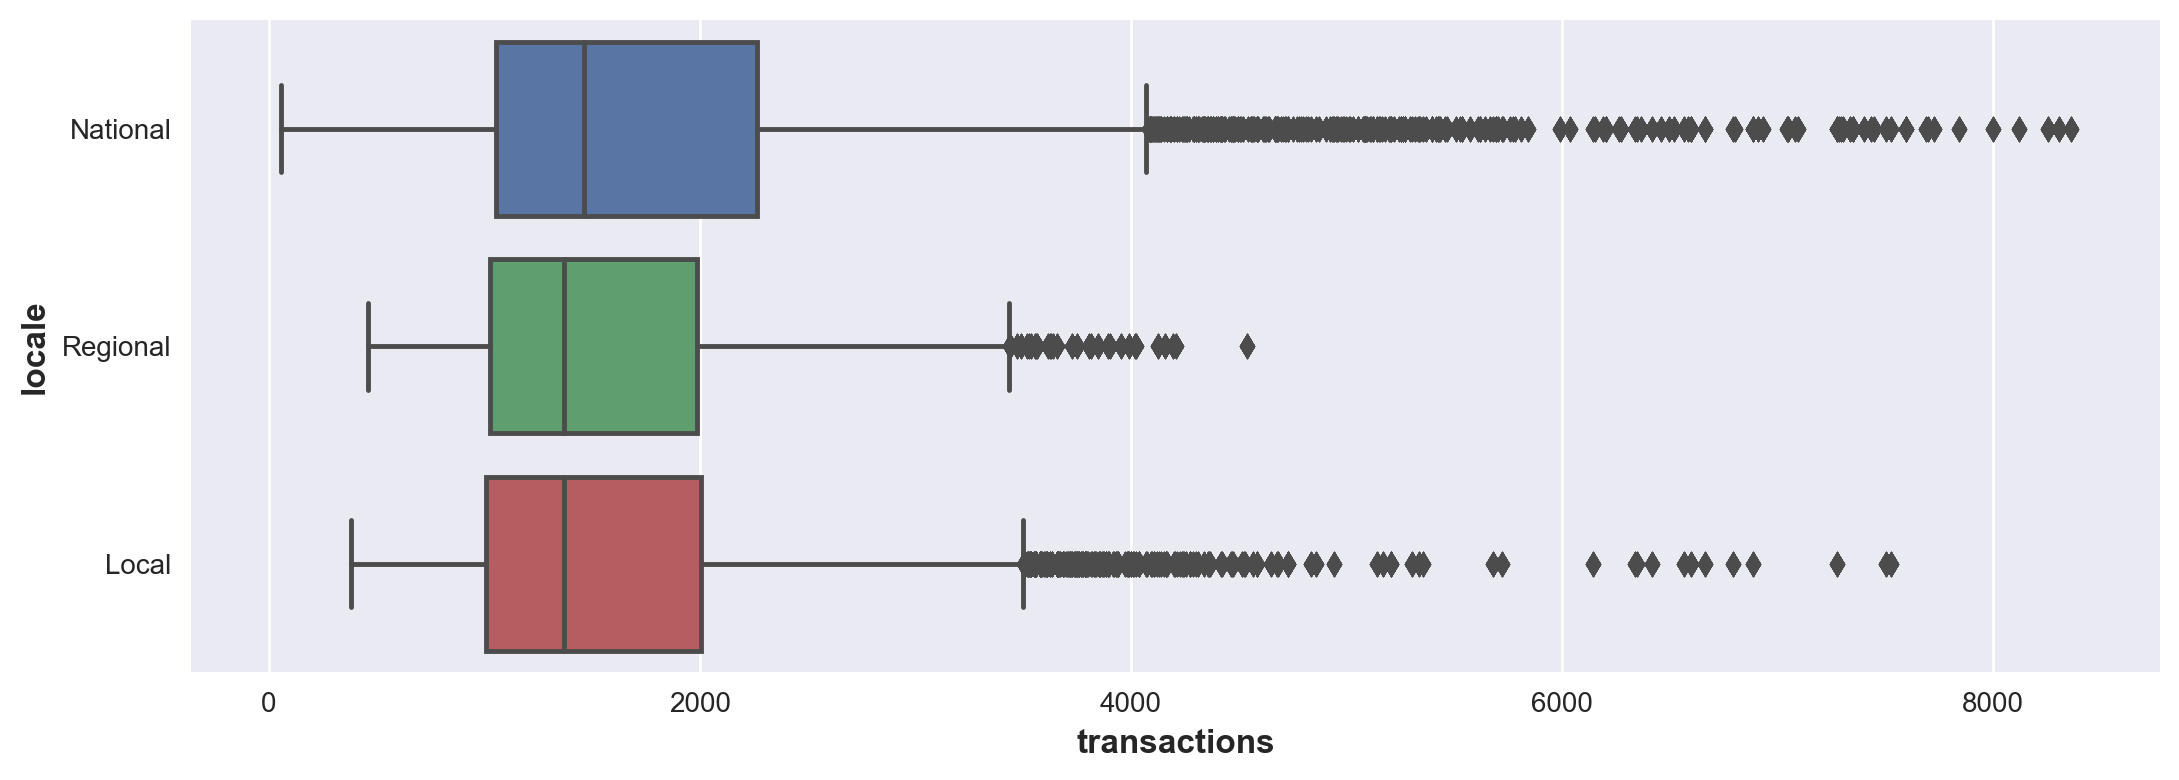

In [37]:
# Create a boxplot of the 'transactions' column grouped by 'locale'
sns.boxplot(x='transactions', y='locale', data=train_merged)

# Show the plot
plt.show()

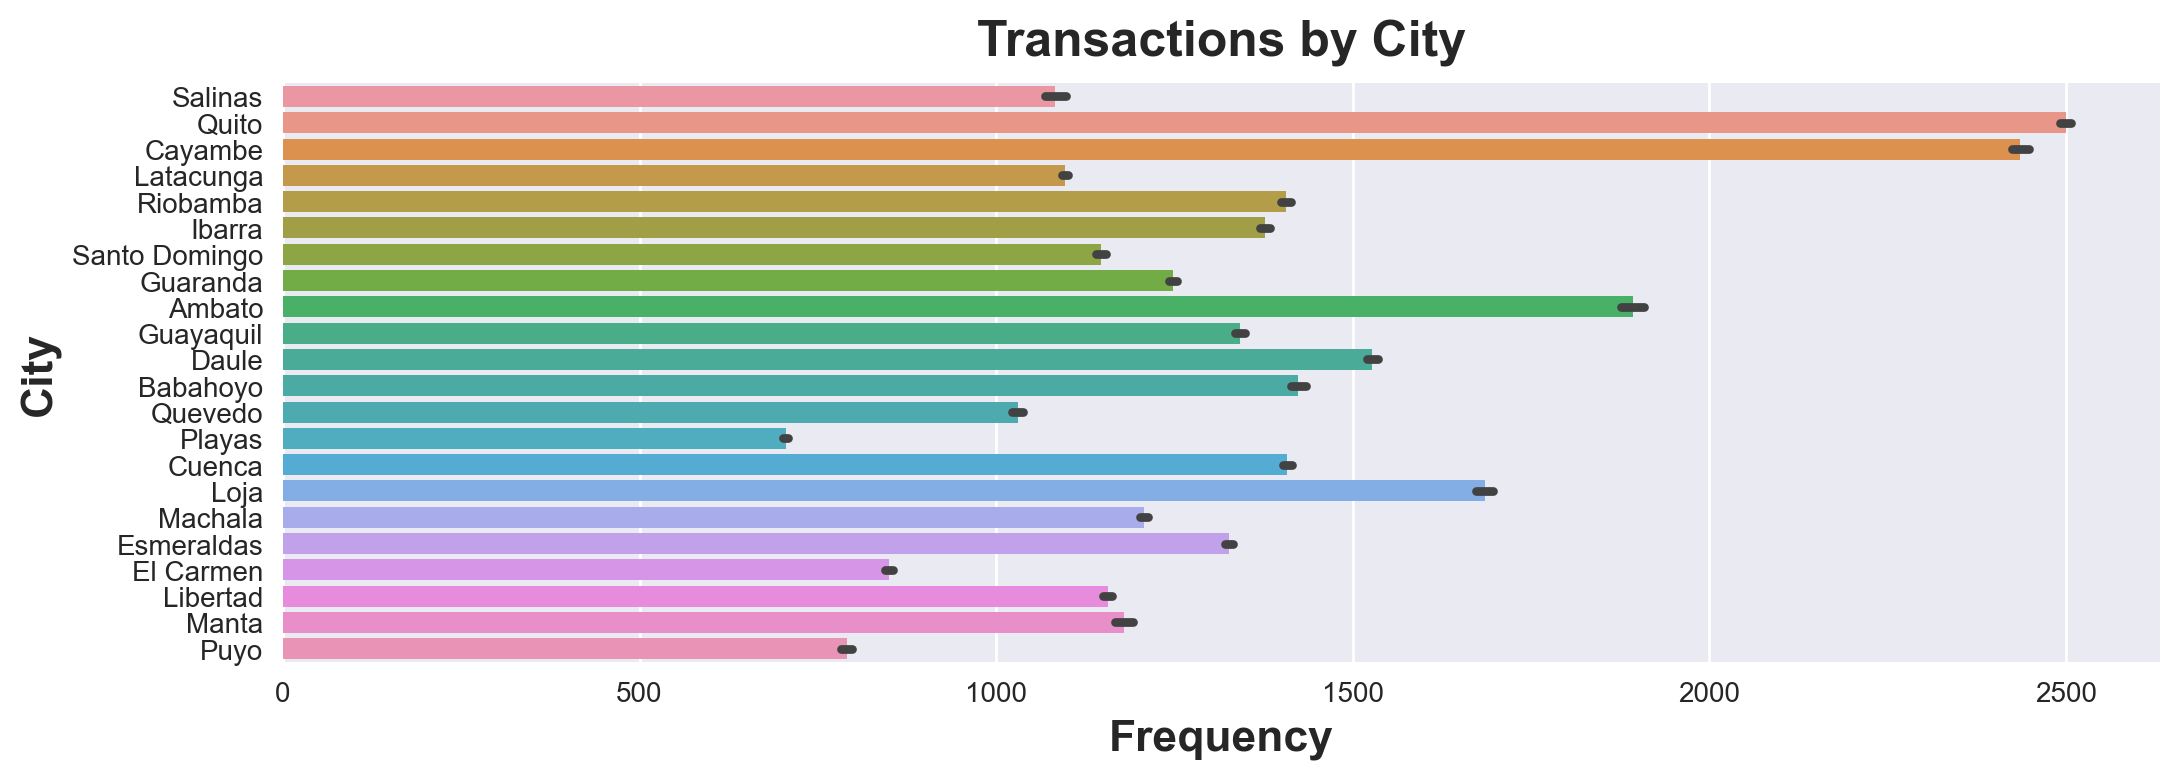

In [38]:
# Create a boxplot of transactions by City
sns.barplot(x='transactions', y='city', data=train_merged)

width=0.5,  # Adjust the width of the boxes
fliersize=3, # Adjust the size of the outliers
showmeans=True, # Show the mean value
meanline=True, # Show a line for the mean
notch=True, # Make the boxes "notched"

# Add a title and labels for the x and y axis
plt.title('Transactions by City', fontsize=18)
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('City', fontsize=16)

# Show the plot
plt.show()

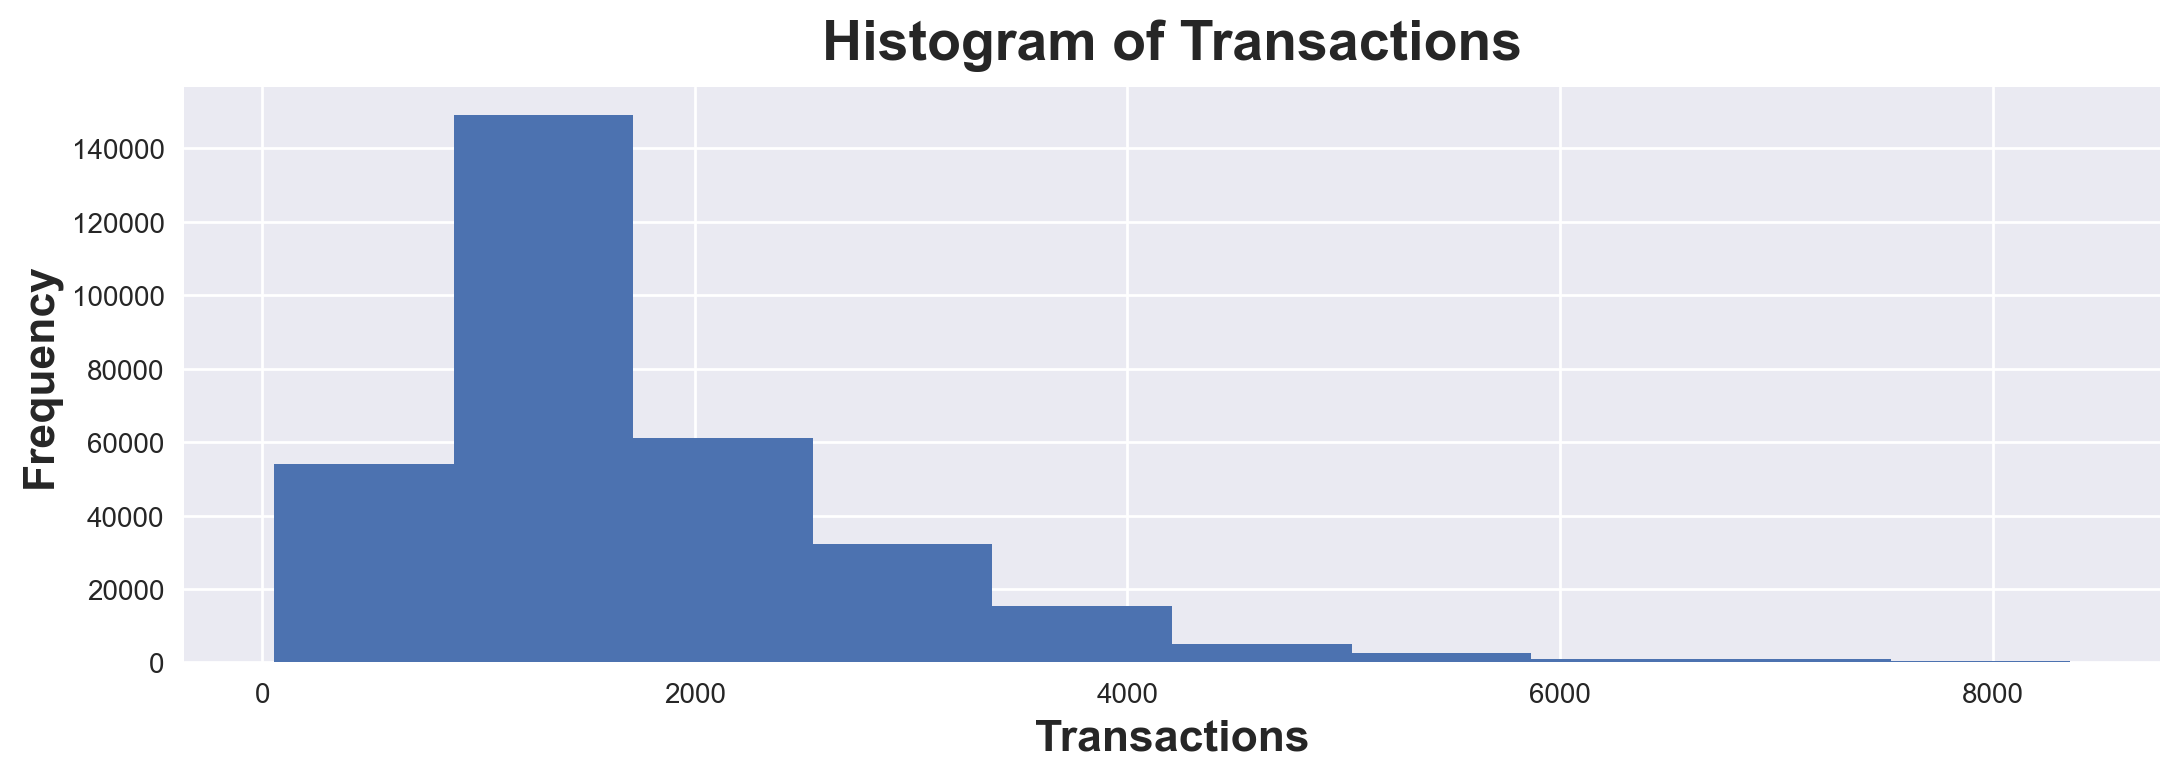

In [39]:
# Create a histogram of the 'transactions' column
train_merged.transactions.hist()

# Add labels to the x-axis, y-axis, and title
plt.xlabel('Transactions', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Histogram of Transactions', fontsize=20)

# Show the plot
plt.show()

<Axes: >

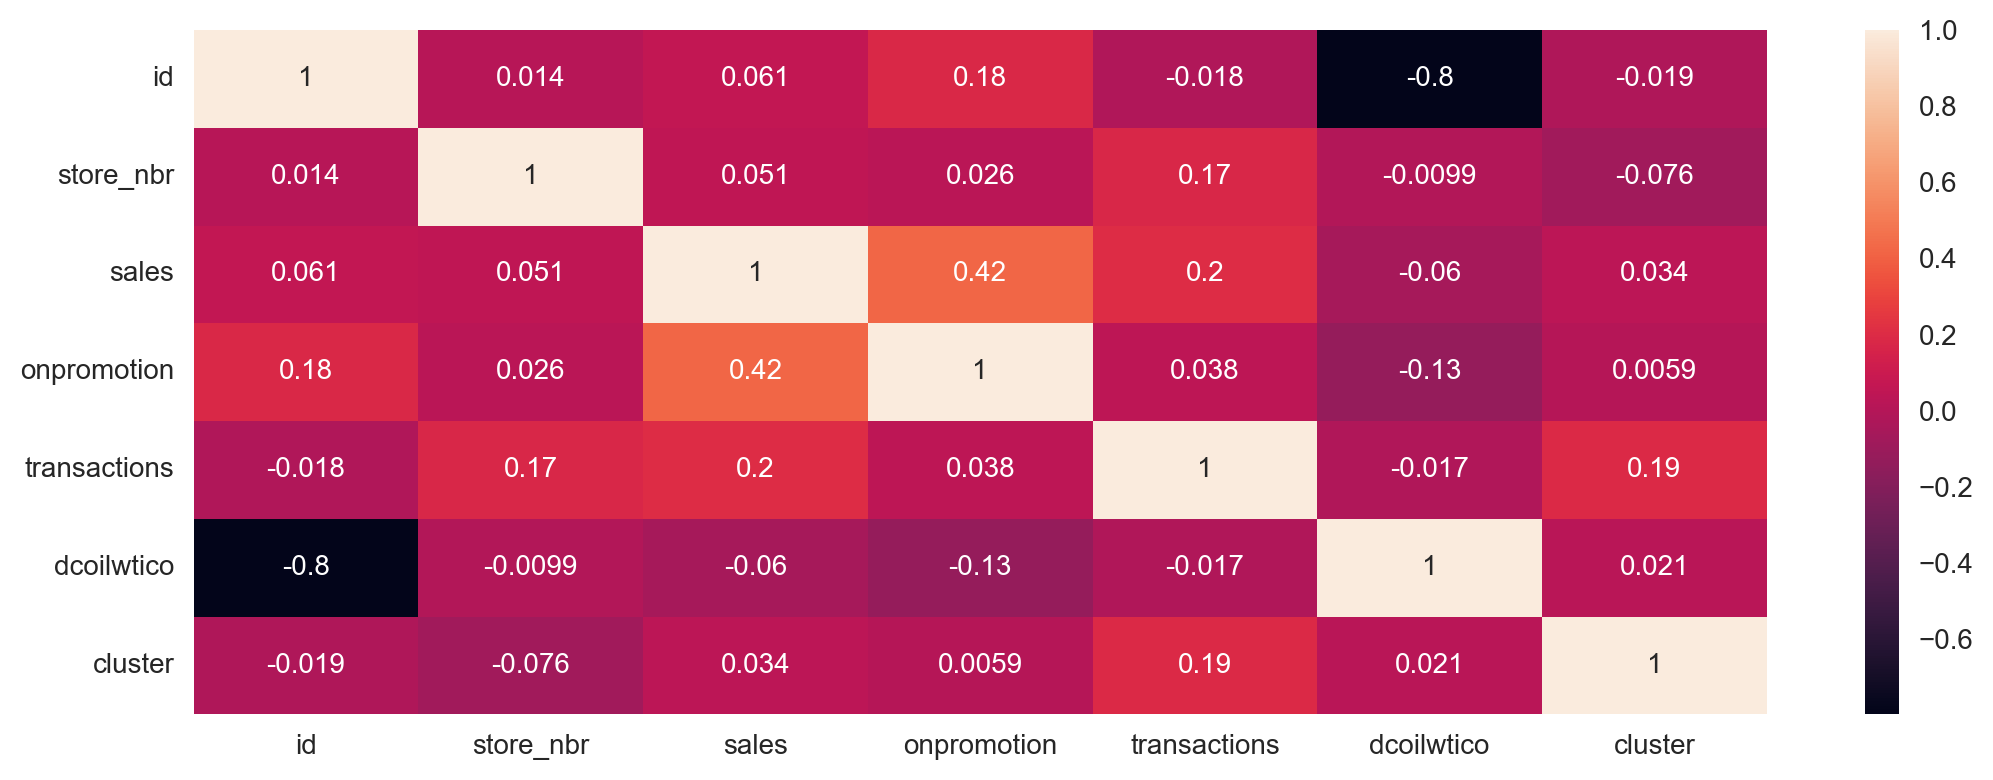

In [40]:
# Create a DataFrame of train_data with numerical columns only
train_merged_num = train_merged.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix of the numerical columns
corr_matrix = train_merged_num.corr()

# Visualizing the correlation matrix with a heatmap
sns.heatmap(corr_matrix, annot=True)

# Save the chart as an image file
# plt.savefig('Correlation of the numerical columns of the train dataset.png')

In [41]:
# Create new features from the 'date' column using pandas' powerful time-based indexing

train_merged['year'] = train_merged.date.dt.year
train_merged['month'] = train_merged.date.dt.month
train_merged['dayofmonth'] = train_merged.date.dt.day
train_merged['dayofweek'] = train_merged.date.dt.dayofweek
train_merged['dayname'] = train_merged.date.dt.strftime('%A')

train_merged.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,...,dcoilwtico,city,state,store_type,cluster,year,month,dayofmonth,dayofweek,dayname
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,770,Holiday,National,Ecuador,...,67.714366,Salinas,Santa Elena,D,1,2013,1,1,1,Tuesday
1,562,2013-01-01,25,BABY CARE,0.0,0,770,Holiday,National,Ecuador,...,67.714366,Salinas,Santa Elena,D,1,2013,1,1,1,Tuesday
2,563,2013-01-01,25,BEAUTY,2.0,0,770,Holiday,National,Ecuador,...,67.714366,Salinas,Santa Elena,D,1,2013,1,1,1,Tuesday
3,564,2013-01-01,25,BEVERAGES,810.0,0,770,Holiday,National,Ecuador,...,67.714366,Salinas,Santa Elena,D,1,2013,1,1,1,Tuesday
4,565,2013-01-01,25,BOOKS,0.0,0,770,Holiday,National,Ecuador,...,67.714366,Salinas,Santa Elena,D,1,2013,1,1,1,Tuesday


In [42]:
# Display random sample of 8 rows

train_merged.sample(8, random_state = 42)

,id,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,...,dcoilwtico,city,state,store_type,cluster,year,month,dayofmonth,dayofweek,dayname
126263,2830580,2017-05-12,30,BREAD/BAKERY,143.000,2,743,Holiday,Local,Puyo,...,47.830002,Guayaquil,Guayas,C,3,2017,5,12,4,Friday
172108,551707,2013-11-06,39,GROCERY II,28.000,0,1275,Holiday,Regional,Santo Domingo de los Tsachilas,...,94.739998,Cuenca,Azuay,B,6,2013,11,6,2,Wednesday
170862,2704338,2017-03-02,38,LINGERIE,8.000,0,1426,Holiday,Local,Manta,...,52.630001,Loja,Loja,D,4,2017,3,2,3,Thursday
233825,2184356,2016-05-13,48,LAWN AND GARDEN,6.000,0,2438,Event,National,Ecuador,...,46.220001,Quito,Pichincha,A,14,2016,5,13,4,Friday
326,312431,2013-06-25,25,LAWN AND GARDEN,2.000,0,515,Holiday,Local,Latacunga,...,95.250000,Salinas,Santa Elena,D,1,2013,6,25,1,Tuesday
31788,2999214,2017-08-15,12,DELI,145.000,6,1096,Holiday,Local,Riobamba,...,47.570000,Latacunga,Cotopaxi,C,15,2017,8,15,1,Tuesday
149188,1841725,2015-11-02,34,POULTRY,145.608,0,1766,Holiday,National,Ecuador,...,46.119999,Guayaquil,Guayas,B,6,2015,11,2,0,Monday
225820,1692472,2015-08-10,47,BABY CARE,0.000,0,4049,Holiday,National,Ecuador,...,44.939999,Quito,Pichincha,A,14,2015,8,10,0,Monday


In [43]:
# Set the 'date' column as index

train_merged = train_merged.set_index('date')
train_merged.head()

,id,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,...,dcoilwtico,city,state,store_type,cluster,year,month,dayofmonth,dayofweek,dayname
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,561,25,AUTOMOTIVE,0.0,0,770,Holiday,National,Ecuador,Primer dia del ano,...,67.714366,Salinas,Santa Elena,D,1,2013,1,1,1,Tuesday
2013-01-01,562,25,BABY CARE,0.0,0,770,Holiday,National,Ecuador,Primer dia del ano,...,67.714366,Salinas,Santa Elena,D,1,2013,1,1,1,Tuesday
2013-01-01,563,25,BEAUTY,2.0,0,770,Holiday,National,Ecuador,Primer dia del ano,...,67.714366,Salinas,Santa Elena,D,1,2013,1,1,1,Tuesday
2013-01-01,564,25,BEVERAGES,810.0,0,770,Holiday,National,Ecuador,Primer dia del ano,...,67.714366,Salinas,Santa Elena,D,1,2013,1,1,1,Tuesday
2013-01-01,565,25,BOOKS,0.0,0,770,Holiday,National,Ecuador,Primer dia del ano,...,67.714366,Salinas,Santa Elena,D,1,2013,1,1,1,Tuesday


Text(0.5, 0, 'Year')

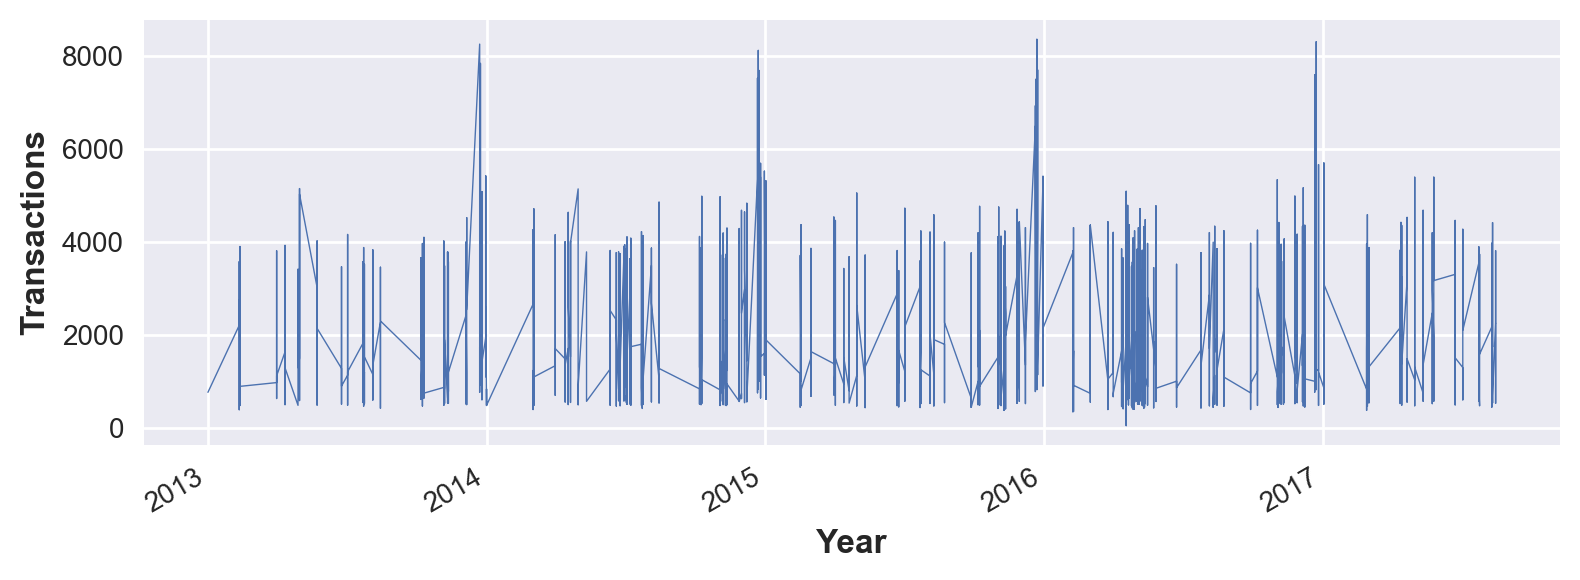

In [44]:
# Visualize the 'transactions' column

plt.figure(figsize=(8,3))
ax = train_merged['transactions'].plot(linewidth=0.5)
ax.set_ylabel('Transactions')
ax.set_xlabel('Year')

The plot above reveals that transactions are always highest at the end of each year. This reveals seasonality in the dataset.

In [45]:
# # Check for stationarity using adfuller

# result = adfuller(train_merged['transactions'])

# print(f'Test Statistics: {result[0]}')
# print(f'p-value: {result[1]}')
# print(f'Critical Values: {result[4]}')

# if result[1] > 0.05 :
#     print('Series is not stationary')
# else:
#     print('Series is stationary')

In [46]:
# Checking for the frequency of the 'date' column

pd.date_range('2013-01-01','2013-01-31', freq='D')

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10', '2013-01-11', '2013-01-12',
               '2013-01-13', '2013-01-14', '2013-01-15', '2013-01-16',
               '2013-01-17', '2013-01-18', '2013-01-19', '2013-01-20',
               '2013-01-21', '2013-01-22', '2013-01-23', '2013-01-24',
               '2013-01-25', '2013-01-26', '2013-01-27', '2013-01-28',
               '2013-01-29', '2013-01-30', '2013-01-31'],
              dtype='datetime64[ns]', freq='D')

The result above shows that the 'date' column exists in daily frequency.

In [47]:
# # Create an autocorrelation plot

# pd.plotting.autocorrelation_plot(train_merged['2013':'2017']['transactions'])

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

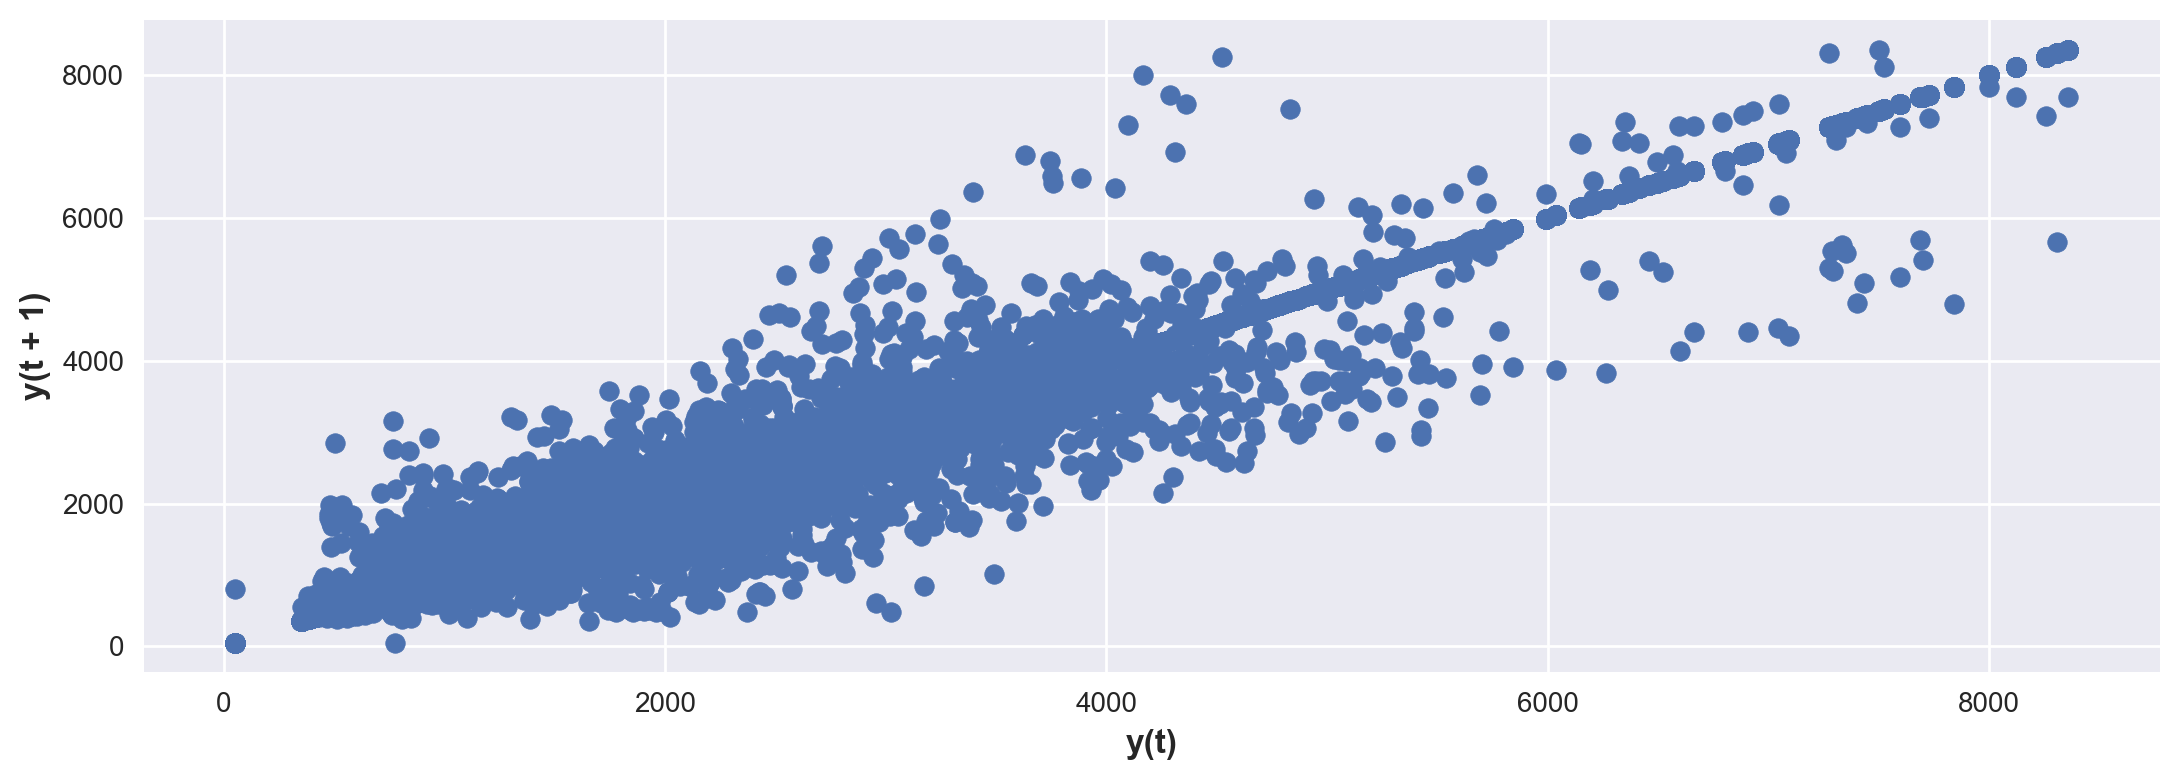

In [48]:
# Create a lag plot

pd.plotting.lag_plot(train_merged['transactions'], lag=1)

In [49]:
# Resample to weekly frequency and aggregate to mean

train_merged_weekly_mean = train_merged['transactions'].resample('W').mean()
train_merged_weekly_mean

date
2013-01-06     770.000000
2013-01-13            NaN
2013-01-20            NaN
2013-01-27            NaN
2013-02-03            NaN
                 ...     
2017-07-23            NaN
2017-07-30    1546.759259
2017-08-06            NaN
2017-08-13    1598.287037
2017-08-20    1602.981481
Freq: W-SUN, Name: transactions, Length: 242, dtype: float64

# Hypothesis Testing

# Answering Analytical Questions

### Questions

1. Is the train dataset complete (has all the required dates)?

2. Which dates have the lowest and highest sales for each year?

3. Did the earthquake impact sales?

4. Are certain groups of stores selling more products? (Cluster, city, state, type)

5. Are sales affected by promotions, oil prices and holidays?

6. What analysis can we get from the date and its extractable features?

7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

### Question 1

Is the train dataset complete (has all the required dates)?

In [50]:
# Check for missing values in train dataset
if train.isnull().values.any():
  print("The dataset is not complete. There are missing values.")

# Check for duplicate dates in train dataset
if not train.index.is_unique:
  print("The dataset is not complete. There are duplicate dates.")
else:
  print("The dataset is complete.")

The dataset is complete.


### Question 2

Which dates have the lowest and highest sales for each year?

In [51]:
# Group the data by year and get the minimum and maximum sales for each year
grouped_by_year = df4.groupby('year')['sales'].agg(['min', 'max'])

# Get the dates corresponding to the minimum and maximum sales for each year
result = pd.concat([df4[df4['sales'] == grouped_by_year.loc[year, 'min']][['year', 'date']].rename(columns={'date': 'date_min'}) for year in grouped_by_year.index] +
                  [df4[df4['sales'] == grouped_by_year.loc[year, 'max']][['year', 'date']].rename(columns={'date': 'date_max'}) for year in grouped_by_year.index])

# Set the 'year' column as index
result = result.set_index('year')

# Group the data by year to get the minimum and maximum sales on separate rows
result = result.groupby(level=0).agg({'date_min': 'first', 'date_max': 'first'})

# Reset the index to get a regular dataframe
result = result.reset_index()

# Show the lowest and highest sales for each year
result

,year,date_min,date_max
0,2013,2013-01-01,2013-11-12
1,2014,2014-01-01,2014-12-08
2,2015,2015-01-01,2015-11-11
3,2016,2016-02-08,2016-05-02
4,2017,2017-01-02,2017-01-02


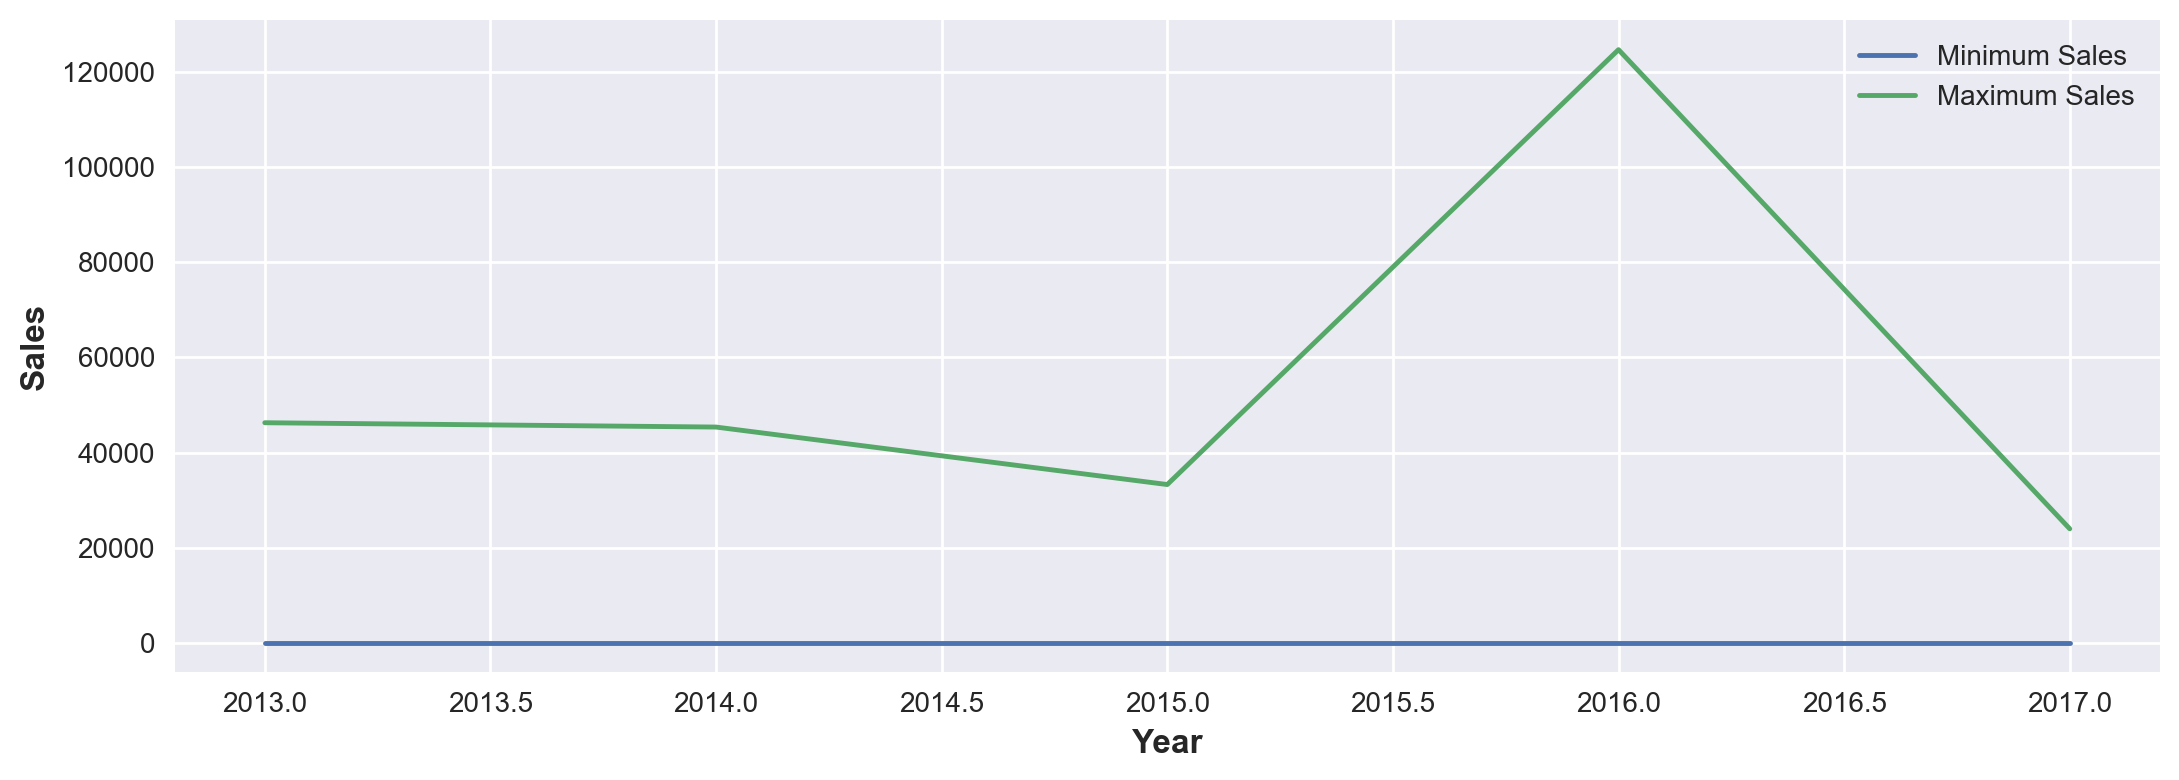

In [52]:
# Plot the minimum and maximum sales for each year
plt.plot(result['year'], grouped_by_year['min'], label='Minimum Sales')
plt.plot(result['year'], grouped_by_year['max'], label='Maximum Sales')

# Add a legend
plt.legend()

# Add axis labels
plt.xlabel('Year')
plt.ylabel('Sales')

# Show the plot
plt.show()

### Question 3

Did the earthquake impact sales?

### Question 4

Are certain groups of stores selling more products? (Cluster, city, state, type)

In [53]:
# Display random sample of 3 rows

train_merged.sample(5, random_state = 42)

,id,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,description,...,dcoilwtico,city,state,store_type,cluster,year,month,dayofmonth,dayofweek,dayname
date,,,,,,,,,,,,,,,,,,,,,
2017-05-12,2830580,30,BREAD/BAKERY,143.0,2,743,Holiday,Local,Puyo,Cantonizacion del Puyo,...,47.830002,Guayaquil,Guayas,C,3,2017,5,12,4,Friday
2013-11-06,551707,39,GROCERY II,28.0,0,1275,Holiday,Regional,Santo Domingo de los Tsachilas,Provincializacion de Santo Domingo,...,94.739998,Cuenca,Azuay,B,6,2013,11,6,2,Wednesday
2017-03-02,2704338,38,LINGERIE,8.0,0,1426,Holiday,Local,Manta,Fundacion de Manta,...,52.630001,Loja,Loja,D,4,2017,3,2,3,Thursday
2016-05-13,2184356,48,LAWN AND GARDEN,6.0,0,2438,Event,National,Ecuador,Terremoto Manabi+27,...,46.220001,Quito,Pichincha,A,14,2016,5,13,4,Friday
2013-06-25,312431,25,LAWN AND GARDEN,2.0,0,515,Holiday,Local,Latacunga,Cantonizacion de Latacunga,...,95.250000,Salinas,Santa Elena,D,1,2013,6,25,1,Tuesday


In [54]:
# Group stores by cluster and count the family of products sold

cluster_products_count = train_merged.groupby(['cluster'], as_index=False).agg({'family':'count'}).sort_values('family', ascending=False)
cluster_products_count

,cluster,family
2,3,44715
9,10,35574
5,6,32736
14,15,31812
13,14,25608
12,13,24354
3,4,19206
7,8,19206
0,1,18546
10,11,13233


As seen in the DataFrame above, some clusters sell more products than others.

In [55]:
# Group stores by city and count the family of products sold

city_products_count = train_merged.groupby(['city'], as_index=False).agg({'family':'count'}).sort_values('family', ascending=False)
city_products_count

,city,family
18,Quito,112266
8,Guayaquil,47784
21,Santo Domingo,16104
3,Cuenca,16005
13,Machala,12804
0,Ambato,12804
10,Latacunga,12606
6,Esmeraldas,6402
7,Guaranda,6402
5,El Carmen,6402


As seen in the DataFrame above, some cities sell more products than others.

In [56]:
# Group stores by state and count the family of products sold

state_products_count = train_merged.groupby(['state'], as_index=False).agg({'family':'count'}).sort_values('family', ascending=False)
state_products_count

,state,family
12,Pichincha,118668
6,Guayas,66825
14,Santo Domingo de los Tsachilas,16104
0,Azuay,16005
4,El Oro,12804
9,Los Rios,12804
15,Tungurahua,12804
3,Cotopaxi,12606
10,Manabi,11979
1,Bolivar,6402


As seen in the DataFrame above, some states sell more products than others.

In [57]:
# Group stores by store_type and count the family of products sold

store_type_product_count = train_merged.groupby(['store_type'], as_index=False).agg({'family':'count'}).sort_values('family', ascending=False)
store_type_product_count

,store_type,family
3,D,110121
2,C,92367
0,A,51645
1,B,45144
4,E,22770


As seen in the DataFrame above, some store_types sell more products than others.

### Question 5

Are sales affected by promotions, oil prices and holidays?

In [58]:
# Create a copy of the train dataset
train_copy = train

Text(0, 0.5, 'Sales')

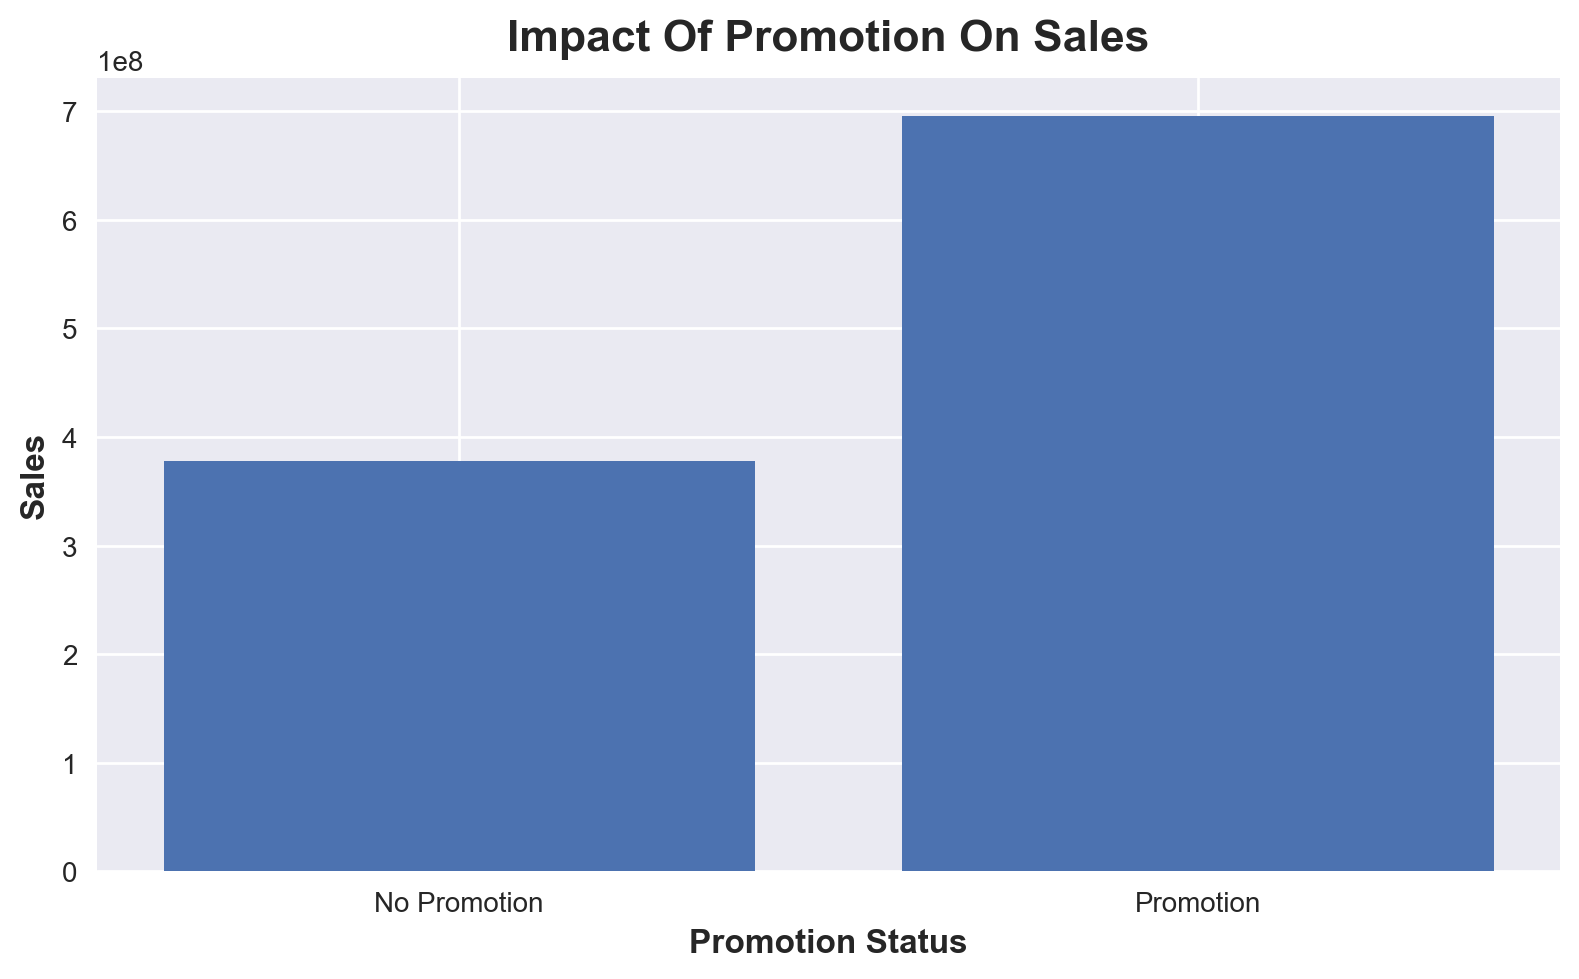

In [59]:
# Identify families with at least one item on promotion and families with no item on promotion
train_copy['onpromotion'] = train_copy['onpromotion'].apply(lambda x: 'No Promotion' if x == 0 else 'Promotion')

# Group by promotion and sum the sales
x = train_copy.groupby(['onpromotion'], as_index=False).agg({'sales':'sum'})

# Plot the sales of promotion and non_promotion families)
plt.figure(figsize=(8,5))
plt.bar(x.onpromotion, x.sales)
plt.title('Impact Of Promotion On Sales')
plt.xticks((0,1))
plt.xlabel('Promotion Status')
plt.ylabel('Sales')

From the chart above, product families with at least one item on promotion had greater sales than families with no item on promotion. This means that sales were affected by promotion.

### Question 6

What analysis can we get from the date and its extractable features?

### Question 7

What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

### Question 8

What is the total sales made each year by the corporation?

In [60]:
# Group by year and sum of sales for each year

sales_per_year = train_merged.groupby(['year'], as_index=False).agg({'sales':'sum'})
sales_per_year

,year,sales
0,2013,1.166394e+07
1,2014,2.809424e+07
2,2015,2.752824e+07
3,2016,4.566470e+07
4,2017,1.792345e+07


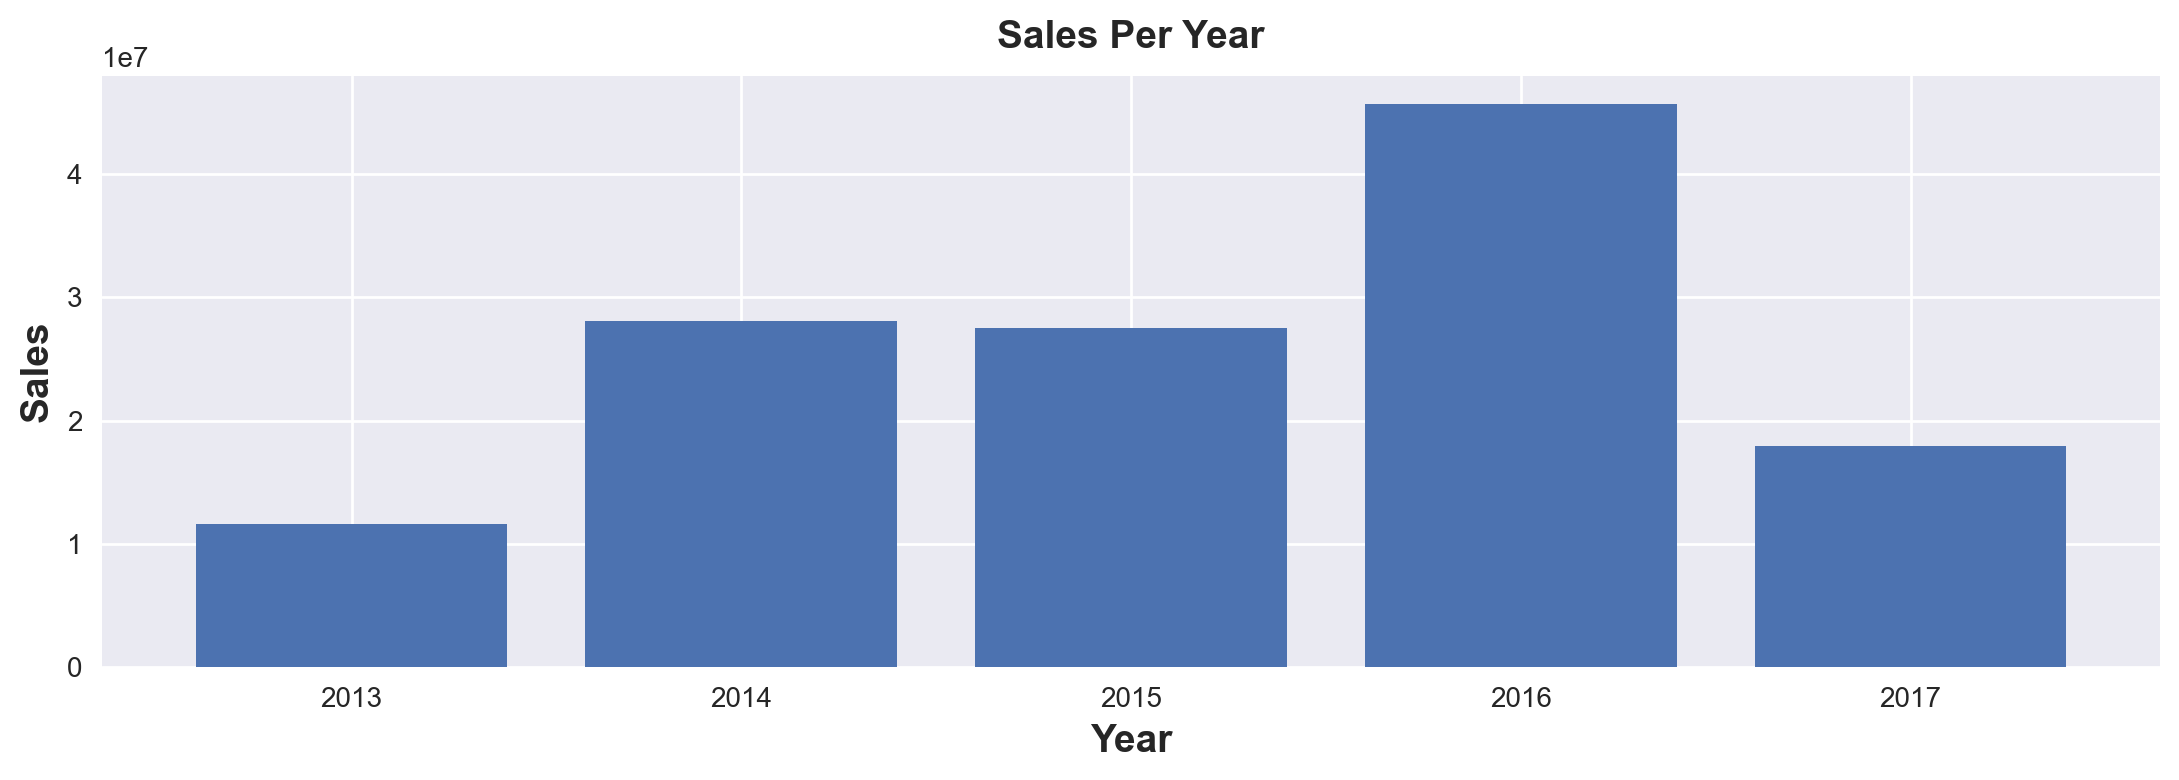

In [61]:
# Plot the sales made each year

plt.bar(sales_per_year.year, sales_per_year.sales)
plt.title('Sales Per Year',fontsize=14)
plt.ylabel('Sales',fontsize=14)
plt.xlabel('Year',fontsize=14)
plt.show()

From the data provided, Corporation Favorita made it's lowest sales in 2013 and its highest sales in 2016.